In [3]:
import sys 
sys.path.append('../..')
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
from sklearn.linear_model import LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import IPython
import torch as ch
from torch import Tensor
from torch.distributions import Uniform
from torch.distributions.transforms import SigmoidTransform
from torch.distributions.transformed_distribution import TransformedDistribution
from torch.utils.data import DataLoader
from delphi.stats.truncated_logistic_regression import truncated_logistic_regression
from delphi.oracle import Left, Interval
from delphi.utils.helpers import logistic
import delphi.utils.constants as consts
from delphi.utils.helpers import Bounds
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

if ch.cuda.is_available(): 
    ch.set_default_tensor_type(ch.cuda.FloatTensor)
    print("cuda tensors...")

cuda tensors...


# Helpers

In [4]:
# EXP_NAME = 'TruncatedLogisticRegressionWeightDecay'
# EXP_NAME = 'TruncatedLogisticRegression1e-1'
EXP_NAME = '2500steps'
STORE_PATH = '/home/gridsan/stefanou/LogisticRegression/' + EXP_NAME
STORE_TABLE_NAME = 'results'

## Default Experiment Parameters

In [9]:
# regression parameters

# procedure hyperparameters
args = Parameters({ 
    'workers': 0, 
    'batch_size': 100,
    'bias': True,
    'num_samples': 1000,
    'samples': 10000, 
    'in_features': 2, 
    'clamp': True, 
    'radius': 5.0, 
    'lr': 1e-1,
    'shuffle': False, 
    'tol': 1e-2,
    'eps': 1e-5,
    'score': True,
    'custom_lr_multiplier': consts.CYCLIC,
    'var': True,
    'momentum': .9, 
    'weight_decay': 5e-4, 
    'trials': 20,
    'lower': -1, 
    'upper': 1,
    'epochs': 25,
    'steps': 2500,
})

if ch.cuda.is_available(): 
    args.__setattr__('device', 'cuda')
    print("using cuda...")
else: 
    args.__setattr__('device', 'cpu')

using cuda...


# Experiment

In [ ]:
# create store
store = Store(STORE_PATH)

store.add_table(STORE_TABLE_NAME, { 
    'delphi_cos': float,
    'mle_cos': float,
    'alpha': float, 
    'C': float,
})

# perform each experiment a total of 10 times
for iter_ in range(args.trials): 
    for C in [-2, -1.75, -1.5, -1.25, -1, -.75, -.5, -.25]:
        args.__setattr__('phi', Left(Tensor([C])))
        
        # generate random uniform weights        
        ground_truth = ch.nn.Linear(in_features=args.in_features, out_features=1, bias=args.bias)
        ground_truth.weight = ch.nn.Parameter(Uniform(args.lower, args.upper).sample(ch.Size([1, args.in_features])))
        if ground_truth.bias is not None: 
            ground_truth.bias = ch.nn.Parameter(Uniform(args.lower, args.upper).sample(ch.Size([1,])))

        # generate data
        X = Uniform(-5, 5).sample(ch.Size([args.samples, args.in_features]))
        z = ground_truth(X) + logistic.sample(ch.Size([args.samples, 1])).cuda()
        y = ch.where(z > 0, ch.ones(1), ch.zeros(1))

        # truncate
        indices = args.phi(z).nonzero(as_tuple=False).flatten()
        z_trunc, y_trunc, x_trunc = z[indices], y[indices], X[indices]
        args.__setattr__('alpha', Tensor([y_trunc.size(0) / args.samples]))

        # truncated logistic regression
        trunc_log_reg = truncated_logistic_regression(args.phi, args.alpha, args)
        results = trunc_log_reg.fit(x_trunc.cpu(), y_trunc.cpu())
        w, w0 = results.weight.detach().cpu(), results.bias.detach().cpu()
        
        # naive estimates 
        naive_log_reg = LogisticRegression(penalty='none')
        naive_log_reg.fit(x_trunc.cpu(), y_trunc.cpu().flatten())

        # parameter estimates 
        real_params = ch.cat([ground_truth.weight, ground_truth.bias.unsqueeze(0)], axis=1)
        mle_params = ch.cat([Tensor(naive_log_reg.coef_), Tensor(naive_log_reg.intercept_).unsqueeze(0)], axis=1)
        delphi_params = ch.cat([w, w0.unsqueeze(0)], axis=1)

        store[STORE_TABLE_NAME].append_row({ 
            'delphi_cos': ch.nn.functional.cosine_similarity(delphi_params.cuda(), Tensor(real_params).cuda()),
            'mle_cos': ch.nn.functional.cosine_similarity(mle_params, real_params),
            'alpha': float(args.alpha),
            'C': C,
        })
        
        IPython.display.clear_output(wait=False)

# close current store
store.close()

==> Preparing dataset truncated_logistic_regression..


# Results

In [7]:
reader = CollectionReader(STORE_PATH)
results = reader.df(STORE_TABLE_NAME)
reader.close() # close reader
results.head()

100%|██████████| 1/1 [00:00<00:00, 148.67it/s]


,delphi_cos,mle_cos,alpha,C,exp_id
0,0.859747,0.933698,0.8005,-2.00,d55f9527-db08-490e-812d-e0fc862ad35a
1,0.959080,0.826603,0.6328,-1.75,d55f9527-db08-490e-812d-e0fc862ad35a
2,0.973499,0.316754,0.6442,-1.50,d55f9527-db08-490e-812d-e0fc862ad35a
3,0.880785,0.811080,0.6706,-1.25,d55f9527-db08-490e-812d-e0fc862ad35a
4,0.983853,0.911434,0.7111,-1.00,d55f9527-db08-490e-812d-e0fc862ad35a


# All Trials

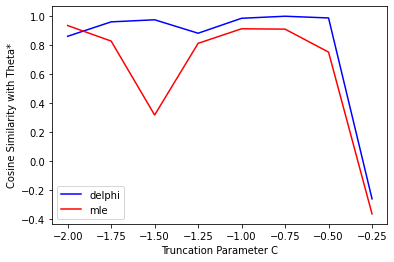

In [8]:
# variance vs param mse
sns.lineplot(data=results, x='C', y='delphi_cos', label='delphi', color='blue')
ax = sns.lineplot(data=results, x='C', y='mle_cos', label='mle', color='red')
ax.set(xlabel='Truncation Parameter C', ylabel='Cosine Similarity with Theta*')
plt.show()

In [17]:
len(results[results['C'] == -.25]['mle_cos'])

60

In [7]:
filtered = Tensor([[[0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.]]])

stuff = Tensor([[0, 1, 0, 0, 0, 0, 1, 0, 1, 0]]).eq(Tensor([0, 1, 0, 0, 0, 0, 0, 0, 1, 0]))[...,None]

stuff * filtered

tensor([[[0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.]]])

In [8]:
stuff

tensor([[[ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [False],
         [ True],
         [ True],
         [ True]]])

In [12]:
1 - ch.exp(-Tensor([-0.2534]))

tensor([-0.2884])

In [ ]:
inner_exp = Tensor([[[-0.2883,  0.5253],
         [-1.5561,  0.0693],
         [ 0.6731,  0.4460],
         [ 0.6190,  0.5776],
         [ 0.8741,  0.7104],
         [ 0.7807, -1.7973],
         [ 0.4094,  0.8161],
         [-0.8624,  0.8666],
         [ 0.9460,  0.8933],
         [ 0.0144,  0.5563]]])


filtered = Tensor([[[0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.]]])

stuff = Tensor([[0, 1, 0, 0, 0, 0, 1, 0, 1, 0]]).eq(Tensor([0, 1, 0, 0, 0, 0, 0, 0, 1, 0]))

In [10]:
test = Tensor([float('-inf')])

In [13]:
test.flatten()[0]

tensor(-inf)

In [15]:
import math 

math.floor(-3.5)

-4

In [16]:
x = ch.randn(3, 2)

In [38]:
class Interval:
    """
    Interval truncation
    """
    # tensor inputs for vector interval truncation
    def __init__(self, lower, upper):
        self.bounds = Bounds(lower, upper)

    def __call__(self, x):
        # check sample device
        if x.is_cuda:
            return ((self.bounds.lower.cuda() < x).prod(-1) * (x < self.bounds.upper.cuda()).prod(-1))
        return ((self.bounds.lower < x).prod(-1) * (x < self.bounds.upper).prod(-1))

In [39]:
test_phi = Interval(ch.full(ch.Size([2,]), -1), ch.full(ch.Size([2,]), 1))

In [43]:
test_phi(noised).unsqueeze(-1).size()

torch.Size([1000, 100, 1])

In [37]:
(noised < test_phi.bounds.lower).prod(-1).size()

torch.Size([1000, 100])